# Replay in Aversive Environments - Localiser decoding

#### _This is a template that will be parameterised and run via [Papermill](http://papermill.readthedocs.io/) for each subject_

This notebook trains a classifier on the localiser data to identify the neural signature associated with each image in the task.

Classification steps:

1. Loading preprocessed data
2. Hyperparameter optimisation
3. Fitting the classifier
4. Producing a confusion matrix to assess classifier performance


## Imports

In [2]:
import os
import sys
sys.path.insert(0, 'code')
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
#from sklearn.externals import joblib
import joblib
from scipy.stats import halfcauchy
from mne.decoding import UnsupervisedSpatialFilter
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from utils import add_features

#from plotting import plot_confusion_matrix

#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from state_prediction import *
from sliding_window_classifiers import *

%matplotlib inline

np.random.seed(100)

## Parameters

In [3]:
# DEFAULT PARAMETERS - OVERRRIDEN BY PAPERMILL EXECUTION
session_id = '001'  # ID of the scanning session
output_dir = 'data/derivatives'  # Where the output data should go
n_stim = 14  # Number of stimuli
classifier_window = [-5, 6]  # Additional timepoints to use as features
classifier_center_idx = 9  # The center index of the classification window, post stimulus onset
n_pca_components = [30, 60]  # Range of PCA components to try when optimising the classifier
param_optimisation_cv = 5  # Folds of CV to use in optimisation
classifier_regularisation = 'l1'  # Type of regularisation to use, l1 or l2
classifier_multiclass = 'ovr'  # Type of multi-class approach to use, ovr for one-vs-the-rest or multiclass
confusion_matrix_cv = 5  # CV to use for making the confusion matrix
n_iter_search = 100  # Number of iterations of the random search parameter optimisation procedure
cores = 1  # Number of cores to use for parallel processing
os.environ['OMP_NUM_THREADS'] = str(cores)

## Get data

In [5]:
#localiser_epochs = mne.read_epochs(os.path.join(output_dir, 'preprocessing/localiser', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz').format(session_id))
#localiser_epochs = mne.read_epochs('E:\Proj\Workspace\sample\MEG\sample\sub-001_localiser_sub-001_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz')
localiser_epochs = mne.read_epochs(os.path.join(output_dir, 'preprocessing', 'sub-{0}', 'localiser', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz').format(session_id))

Reading /content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/data/derivatives/preprocessing/sub-001/localiser/sub-001_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz ...
    Read 5 compensation matrices
    Found the data of interest:
        t =    -500.00 ...     790.00 ms
        5 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated


## Plot the responses to image stimuli in sensor space

We should see an occipital-focused response from around 100ms onwards.

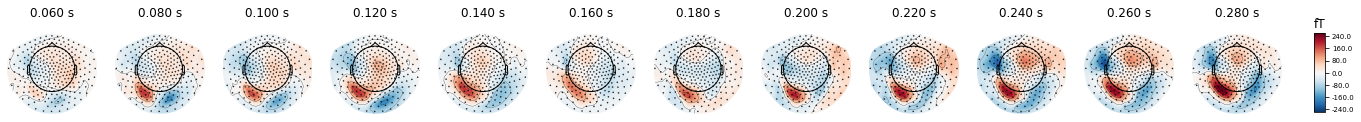

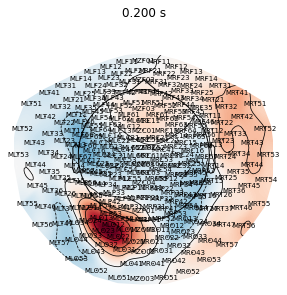

In [6]:
times = np.arange(0.06, 0.3, 0.02)
evoked = localiser_epochs.average()
evoked.plot_topomap(times, ch_type='mag')
evoked.plot_topomap(0.2, ch_type='mag', show_names=True, colorbar=False, size=3, res=128);

## Decoding analysis

### Optimise hyperparameters using randomised search

Optimising regularisation parameter (C) and number of PCA components. Randomised search works like grid search but rather than exhaustively searching a grid of predefined parameter values, it samples from specified parameter distributions. This is useful here because C values closer to 0 tend to be better, but this is not always the case - here we sample C values from a half-Cauchy distribution so that low values are tested more frequently, without us having to manually specify a grid that conforms to this criterion.

To make the process more streamlined, we create a classifier pipeline containing the following steps:
1. Temporal PCA (reducing dimensionality in the channel dimension)
2. Adding features from adjacent timepoints - although we're focusing on a particular timepoint, we add timepoints from before and after this point as additional features. This tends to boost decoding accuracy by ~10%.
3. Scaling the data to be in a standard range.
4. Logistic regression with regularisation and multi-class classification.

This is the iteratively run and evaluated with cross validation across different hyperparameter settings.


In [7]:
# Get epoch data
X_raw = localiser_epochs.get_data()  # MEG signals: n_epochs, n_channels, n_times (exclude non MEG channels)
y_raw = localiser_epochs.events[:, 2]  # Get event types

# select events and time period of interest
picks_meg = mne.pick_types(localiser_epochs.info, meg=True, ref_meg=False)
event_selector = (y_raw < n_stim * 2 + 1)
X_raw = X_raw[event_selector, ...]
y_raw = y_raw[event_selector]
X_raw = X_raw[:, picks_meg, :]

assert len(np.unique(y_raw)) == n_stim, "Found {0} stimuli, expected {1}".format(len(np.unique(y_raw)), n_stim)

print("Number of unique events = {0}\n\nEvent types = {1}".format(len(np.unique(y_raw)),
                                                                  np.unique(y_raw)))

times = localiser_epochs.times

prestim_samples = int(np.abs(localiser_epochs.tmin * localiser_epochs.info['sfreq']))
classifier_center_idx = prestim_samples + classifier_center_idx


# Get data
X, y = (X_raw.copy(), y_raw.copy())
X = X[..., classifier_center_idx + classifier_window[0]:classifier_center_idx + classifier_window[1]] 

# Create null data
X_null = np.zeros((X.shape[0], 272, np.sum(np.abs(classifier_window))))
for n, i in enumerate(np.random.randint(np.sum(np.abs(classifier_window)), prestim_samples, X.shape[0])):
    X_null[n, :, :] = X_raw[n, :, i:np.sum(np.abs(classifier_window)) + i]
y_null = np.ones(X_null.shape[0]) * 99
X = np.vstack([X, X_null])
y = np.hstack([y, y_null])

# Create a pipiline that combines PCA, feature augmentation, scaling, and the logistic regression classifier
clf = make_pipeline(UnsupervisedSpatialFilter(PCA(50), average=False), 
                    FunctionTransformer(add_features, validate=False), StandardScaler(), 
                    LogisticRegression(multi_class=classifier_multiclass, C=0.1, penalty=classifier_regularisation, solver='saga', max_iter=100000, tol=0.2, class_weight="balanced"))

# Parameter distributions passed to the random search procedure
param_dist = {"unsupervisedspatialfilter__estimator__n_components": range(*n_pca_components),
              "logisticregression__C": halfcauchy(scale=5)}

# run randomized search
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=param_optimisation_cv, n_jobs=8, scoring='accuracy', verbose=True)
random_search.fit(X, y)

# Produce a dataframe of the search results
results = pd.DataFrame(random_search.cv_results_)

print("Parameter optimisation done")

Number of unique events = 14

Event types = [ 2  4  6  8 10 12 14 16 18 20 22 24 26 28]
Fitting 5 folds for each of 100 candidates, totalling 500 fits


 Show the results of the optimisation procedure

In [8]:
results.sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_unsupervisedspatialfilter__estimator__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,3.546799,0.220477,0.034400,0.004364,0.085844,38,"{'logisticregression__C': 0.08584400002862833,...",0.391667,0.430556,0.400000,0.391667,0.377778,0.398333,0.017621,1
82,1.433600,0.119132,0.021800,0.002040,0.103018,48,"{'logisticregression__C': 0.10301782629663213,...",0.447222,0.419444,0.383333,0.366667,0.369444,0.397222,0.031279,2
20,3.183000,0.139232,0.030800,0.003655,0.374738,40,"{'logisticregression__C': 0.37473811396885803,...",0.411111,0.425000,0.405556,0.375000,0.361111,0.395556,0.023740,3
1,3.771198,0.485187,0.038000,0.003034,1.912536,40,"{'logisticregression__C': 1.9125355857508377, ...",0.436111,0.408333,0.344444,0.386111,0.391667,0.393333,0.030000,4
67,1.746800,0.347390,0.018799,0.001721,0.12832,33,"{'logisticregression__C': 0.12831994639518107,...",0.419444,0.380556,0.416667,0.377778,0.363889,0.391667,0.022292,5


### Plot the results of hyperparameter optimisation

We can plot the results of the randomised search on a 3D mesh, with the two optimised parameters on the X and Y axes and accuracy on the Z axis. This is produced using [plotly](http://plot.ly/).

In [9]:
init_notebook_mode(connected=True)

trace = go.Mesh3d(x=results.param_logisticregression__C,
                  y=results.param_unsupervisedspatialfilter__estimator__n_components,
                  z=results.mean_test_score, 
                  color='#275fb5', opacity=0.20)

layout = go.Layout(
    title='Hyperparameter optimisation results',
    autosize=True,
    width=700,
    height=700,
    scene = dict(
    xaxis = dict(
        title='Logistic regression C'),
    yaxis = dict(
        title='PCA N components'),
    zaxis = dict(
        title='Mean accuracy'),)
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

### Make confusion matrix with 5-fold CV

The confusion matrix gives us an idea of whether any individual stimuli are being poorly decoded.

Mean accuracy = 0.19333333333333333


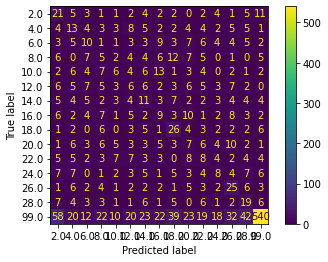

In [23]:
clf.set_params(**random_search.best_params_)

# Get predictions with 5 fold CV
y_pred = cross_val_predict(clf, X, y, cv=confusion_matrix_cv)
mean_conf_mat = confusion_matrix(y, y_pred)
mean_accuracy = accuracy_score(y[y != 99], y_pred[y != 99])
mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1)  # normalise

print("Mean accuracy = {0}".format(mean_accuracy))
    
# Plot mean confusion matrix
#plot_confusion_matrix(mean_conf_mat[:n_stim, :n_stim], title='Normalised confusion matrix, accuracy = {0}'.format(np.round(mean_accuracy, 2)))
#plt.imshow(mean_conf_mat[:n_stim, :n_stim])

ConfusionMatrixDisplay.from_predictions(y, y_pred)
plt.show()

### Save components of the analysis for later use

First save the classifier that was fit to all the localiser data using the best hyperparameter values.

In [ ]:
if not os.path.exists(os.path.join(output_dir, 'classifier', 'classifier_idx_{0}'.format(classifier_center_idx))):
    os.makedirs(os.path.join(output_dir, 'classifier', 'classifier_idx_{0}'.format(classifier_center_idx)))
joblib.dump(random_search.best_estimator_ , os.path.join(output_dir, 'classifier', 
                                                         'classifier_idx_{0}'.format(classifier_center_idx), 'sub-{0}_classifier_idx_{1}.pkl').format(session_id, classifier_center_idx))

['data/derivatives\\classifier\\classifier_idx_59\\sub-001_classifier_idx_59.pkl']

We can save certain details, such as the mean accuracy, so we can analyse them later on.

In [ ]:
accuracy_data = {
    'mean_accuracy': mean_accuracy,
    'best_C': random_search.best_params_['logisticregression__C'],
    'best_n_components': random_search.best_params_['unsupervisedspatialfilter__estimator__n_components']
}

with open(os.path.join(output_dir, 'classifier', 'sub-{0}_classifier_info.json'), 'w') as f:
    json.dump(accuracy_data, f)

And it's helpful to save some data related to classifier performance to create group-level measures of decoding accuracy.

In [ ]:
if not os.path.exists(os.path.join(output_dir, 'localiser_classifier_performance', 'confusion_matrix', 'classifier_idx_{0}'.format(classifier_center_idx))):
    os.makedirs(os.path.join(output_dir, 'localiser_classifier_performance', 'confusion_matrix', 'classifier_idx_{0}'.format(classifier_center_idx)))
np.save(os.path.join(output_dir, 'localiser_classifier_performance', 'confusion_matrix', 'sub-{0}_confusion_matrix_idx_{1}.pkl').format(session_id, classifier_center_idx), mean_conf_mat)